In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
from collections import Counter

# Khám phá dữ liệu

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('data.csv', sep = ',')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
df.shape

(569, 33)

- Dữ liệu trên có 569 dòng và 33 cột.
- Mỗi dòng dữ liệu các đặc điểm của nhân tế bào vú đã được tính toán từ hình ảnh số hóa của một bệnh nhân và chuẩn đoán xem bệnh nhân u lành tính (benign) hay ác tính (malignant).
- Ngoài cột **Unnamed: 32** ra thì không có cột nào thiếu dữ liệu.

In [5]:
# Kiểm tra dòng bị trùng lắp
df.index.duplicated().sum()

0

Ở tập dữ liệu này ta sẽ có cột output là cột **diagnosis** dùng để chuẩn đoán xem bệnh nhân đó có u lành tính hay ác tính

In [6]:
# Cột output có kiểu dữ liệu gì 
df['diagnosis'].dtypes

dtype('O')

B    62.741652
M    37.258348
Name: diagnosis, dtype: float64

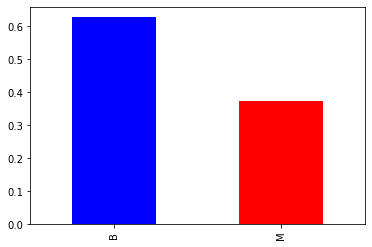

In [7]:
# Tỉ lệ các lớp trong cột output?
df.diagnosis.value_counts(normalize=True).plot(kind="bar", color=["blue", "red"])
df['diagnosis'].value_counts(normalize=True) * 100

Ta thấy được tỉ lệ của số lượng **Benign** là 62.7% và **Malignant** là 37.25%.

# Tiền xử lý

Tách các tập dữ liệu

Đầu tiên ta sẽ bỏ một số cột như sau:
- Bỏ cột **id** đi vì cột này chỉ dùng để định danh cho mỗi dòng dữ liệu, không có ý nghĩa gì trong việc huấn luyện.
- Bỏ cột **Unamed: 32** vì cột này có quá nhiều giá trị thiếu.

In [8]:
# Tách X và y
y_sr = df["diagnosis"] # sr là viết tắt của series
X_df = df.drop(["diagnosis", 'id', 'Unnamed: 32'], axis=1)

Tiếp theo ta sẽ encode cột y_sr về 0 và 1. Nếu như là Maglignant(M) sẽ là 1 còn Benign sẽ là 0

In [9]:
y_sr = np.array([1 if item == 'M' else 0 for item in y_sr])

Ở đây ta sẽ tách ra tập dữ liệu thành hai phần: 
- 90% cho dữ liệu train và validiation
- 10% cho dữ liệu Test cuối 
- Stratify = y_sr để giữ cho tỉ lệ các class như với ban đầu

In [10]:
# Tách tập train và tập test theo tỉ lệ 90%:10%
train_X_df, test_X_df, train_y_sr, test_y_sr = \
                              train_test_split(X_df, y_sr, 
                                               test_size=0.1, 
                                               stratify=y_sr, 
                                               random_state=0)

In [11]:
train_X_df.shape, train_y_sr.shape

((512, 30), (512,))

In [12]:
test_X_df.shape, test_y_sr.shape

((57, 30), (57,))

# Tạo pipeline cho mô hình KNN

Pipeline cho mô hình KNN trên gồm có 2 bước:
- Bước 1: Sử dụng **StandardScaler** để chuẩn hóa các cột của mô hình.
- Bước 2: Áp dụng mô hình KNN để huấn luyện và dự đoán

In [13]:
cancer_pipeline = Pipeline([('normalize', StandardScaler()), ("KNN", KNeighborsClassifier())])

Để có thể đánh giá được với tập dữ liệu trên chạy tốt nhất với tham số **k** là bao nhiêu, ta sẽ thử lần lượt từng con số k để xem kết quả nào cho ra là tốt nhất thông qua phương pháp K-fold cross-validiation để đánh giá.

In [14]:
val_accs = []
param = [item for item in range(1,21)]
best_val_acc = 0
best_k = 0
best_k_test = 0
scores = 0
for k in param:
    cancer_pipeline['KNN'].set_params(n_neighbors=k)
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(cancer_pipeline, train_X_df, train_y_sr, scoring='accuracy', cv=cv, n_jobs=-1)
    print(scores)
    val_acc = scores.mean() * 100
    val_accs.append(val_acc)
    if val_acc > best_val_acc:
        best_k = k
        best_val_acc = val_acc

[0.96153846 0.96153846 0.96078431 0.98039216 1.         0.96078431
 0.96078431 0.96078431 0.90196078 0.98039216]
[0.96153846 0.98076923 0.96078431 0.98039216 0.90196078 0.96078431
 0.96078431 1.         0.92156863 0.96078431]
[0.96153846 0.96153846 0.96078431 1.         0.94117647 0.96078431
 0.96078431 1.         0.90196078 0.98039216]
[0.96153846 0.96153846 0.96078431 0.98039216 0.96078431 0.96078431
 0.96078431 0.98039216 0.92156863 0.98039216]
[0.96153846 0.96153846 0.96078431 1.         0.96078431 0.96078431
 0.98039216 0.98039216 0.94117647 1.        ]
[0.96153846 0.96153846 0.96078431 0.98039216 0.96078431 0.96078431
 0.96078431 0.98039216 0.94117647 1.        ]
[0.96153846 0.96153846 0.96078431 1.         0.96078431 0.96078431
 0.94117647 0.98039216 0.94117647 1.        ]
[0.96153846 0.96153846 0.96078431 0.98039216 0.96078431 0.96078431
 0.94117647 0.98039216 0.94117647 0.98039216]
[0.96153846 0.96153846 0.96078431 0.98039216 0.96078431 0.96078431
 0.94117647 0.98039216 0.9411

Visualize kết quả

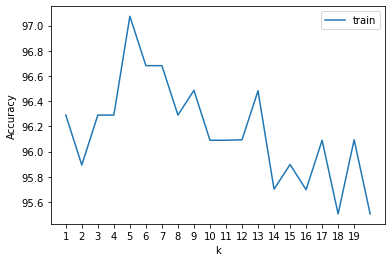

Best val_accuracy:  97.0739064856712
Best k:  5


In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(param, val_accs, color='tab:blue', label='train')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(np.arange(1,20))
plt.show()
print('Best val_accuracy: ', best_val_acc)
print('Best k: ', best_k)

Như vậy với kết quả trên ta sẽ sử dụng model KNN với siêu tham số k = 5

Cuối cùng, ta sẽ sử dụng tham số k tốt nhất đã tìm được và sử dụng để huấn luyện mô hình dự đoán trên tập test

In [16]:
cancer_pipeline['KNN'].set_params(n_neighbors=5)
cancer_pipeline.fit(train_X_df, train_y_sr)
cancer_pipeline.score(test_X_df, test_y_sr) * 100

92.98245614035088

Như vậy độ chính xác của mô hình này là **92,98%**

# Save model

In [17]:
from joblib import dump, load

dump(cancer_pipeline, 'cancer_pipeline.joblib')

['cancer_pipeline.joblib']

load model

In [18]:
from sklearn.metrics import accuracy_score
loaded_model =load('cancer_pipeline.joblib') 
result = loaded_model.predict(test_X_df) 
accuracy_score(test_y_sr, result)

0.9298245614035088

In [56]:
a = pd.DataFrame(test_X_df.loc[430]).T
a

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
430,14.9,22.53,102.1,685.0,0.09947,0.2225,0.2733,0.09711,0.2041,0.06898,0.253,0.8749,3.466,24.19,0.006965,0.06213,0.07926,0.02234,0.01499,0.005784,16.35,27.57,125.4,832.7,0.1419,0.709,0.9019,0.2475,0.2866,0.1155


In [55]:
loaded_model.predict(a)

array([1])

In [57]:
def model_result(model_dir, input_data):
    from joblib import load
    loaded_model =load(model_dir)
    result = loaded_model.predict(input_data)[0]
    return result

In [58]:
model_result('cancer_pipeline.joblib', a)

1